In [1]:
# @title
# ===============================
# GAME CELL with Progressive Difficulty
# ===============================
import random
import time
import numpy as np

class TrainGameEnv:
    def __init__(self, initial_capacity=100, seed=None, verbose=False):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        # train
        self.initial_capacity = initial_capacity
        self.capacity = initial_capacity
        self.passengers_onboard = 0

        # scoring trackers
        self.raw_score = 0.0
        self.total_boarded = 0
        self.total_unused = 0.0
        self.total_config_cost = 0.0

        # stations
        self.stations = [
            "Recto", "Legarda", "Pureza", "V. Mapa", "J. Ruiz", "Gilmore",
            "Betty Go", "Cubao", "Anonas", "Katipunan",
            "Santolan", "Marikina", "Antipolo"
        ]
        self.num_stations = len(self.stations)
        self.station_idx = 0
        self.direction = +1

        # collapse mechanic
        self.weight_window = []
        self.window_size = 10
        self.collapse_threshold = 10.0  # will shrink with time (soft pressure)

        # time simulation
        self.sim_hour = random.randint(0,23)
        self.steps = 0
        self.max_steps = 2000

        # bookkeeping
        self.station_visits = 0
        self.history = []
        self.done = False
        self.done_reason = None
        self.verbose = verbose

    # ---------- helpers ----------
    def _time_multiplier(self, hour):
        if 6 <= hour <= 8:
            return 1.9
        if 11 <= hour <= 13:
            return 1.6
        if 17 <= hour <= 19:
            return 1.9
        return 0.8 if random.random() < 0.45 else 1.0

    def _arrival_bounds(self, idx):
        if idx in (0, self.num_stations-1, 7):
            return (40, 150)
        return (10, 70)

    def _simulate_arrivals(self):
        amin, amax = self._arrival_bounds(self.station_idx)
        base = random.randint(amin, amax)
        mult = self._time_multiplier(self.sim_hour)

        # === Passenger Surge Scaling ===
        surge_factor = 1.0 + (self.steps / 2000) * 2.0  # grows up to 3x
        return max(0, int(round(base * mult * surge_factor)))

    def reset(self):
        self.capacity = self.initial_capacity
        self.passengers_onboard = 0
        self.raw_score = 0.0
        self.total_boarded = 0
        self.total_unused = 0.0
        self.total_config_cost = 0.0
        self.station_idx = 0
        self.direction = +1
        self.weight_window = []
        self.collapse_threshold = 10.0
        self.sim_hour = random.randint(0,23)
        self.steps = 0
        self.station_visits = 0
        self.history = []
        self.done = False
        self.done_reason = None
        return self._get_state()

    def _get_state(self):
        return np.array([
            float(self.capacity),
            float(self.passengers_onboard),
            float(self.station_idx),
            float(self.direction),
            float(self.sim_hour)
        ], dtype=np.float32)

    # ---------- main step ----------
    def step(self, action):
        if self.done:
            raise RuntimeError("Environment is done. Call reset().")

        # action effects
        if action == 0:
            self.capacity += 100
            cost = 10.0
            weight = 1.0
        elif action == 1:
            self.capacity += 50
            cost = 5.0
            weight = 0.5
        else:
            cost = 0.0
            weight = 0.0

        config_penalty = 0.5 * cost
        self.total_config_cost += cost
        self.raw_score -= config_penalty

        # collapse check
        self.weight_window.append(weight)
        if len(self.weight_window) > self.window_size:
            self.weight_window.pop(0)
        window_sum = sum(self.weight_window)

        # === Soft Collapse Pressure ===
        self.collapse_threshold = max(3.0, 10.0 - (self.steps / 200))  # shrinks over time

        if window_sum >= self.collapse_threshold:
            self.done = True
            self.done_reason = f"Collapse: running weight {window_sum:.2f} >= {self.collapse_threshold:.2f}"
            self.raw_score -= 200.0
            return self._get_state(), -500.0, True, {"reason": self.done_reason}

        # alighting
        if self.passengers_onboard > 0:
            alight = random.randint(0, self.passengers_onboard)
            self.passengers_onboard -= alight
        at_terminal = (self.station_idx == 0 or self.station_idx == self.num_stations-1)
        if at_terminal:
            self.passengers_onboard = 0

        # arrivals + boarding
        arrivals = self._simulate_arrivals()
        space = max(0, self.capacity - self.passengers_onboard)
        boarded = min(arrivals, space)
        self.passengers_onboard += boarded

        unused = max(0, self.capacity - self.passengers_onboard)

        # === Penalty Growth ===
        penalty_growth = 1.0 + (self.steps / 1000)  # penalties double after ~1000 steps

        reward_board = 2.0 * boarded
        penalty_unused = 0.1 * unused * penalty_growth
        station_reward = reward_board - penalty_unused

        # trackers
        self.raw_score += station_reward
        self.total_boarded += boarded
        self.total_unused += unused
        self.station_visits += 1
        self.steps += 1
        self.sim_hour = (self.sim_hour + random.randint(0,2)) % 24

        hist_row = {
            "step": self.steps,
            "station_idx": self.station_idx,
            "station_name": self.stations[self.station_idx],
            "action": {0:"Dagdag",1:"Lapad",2:"None"}[action],
            "capacity": self.capacity,
            "boarded": boarded,
            "onboard": self.passengers_onboard,
            "unused": unused,
            "station_reward": station_reward,
            "raw_score": self.raw_score,
            "collapse_threshold": self.collapse_threshold
        }
        self.history.append(hist_row)

        # move train
        next_idx = self.station_idx + self.direction
        if next_idx < 0 or next_idx >= self.num_stations:
            self.direction *= -1
            next_idx = self.station_idx + self.direction
        if self.steps >= self.max_steps:
            self.done = True
            self.done_reason = "Max steps reached."
        self.station_idx = next_idx

        if self.verbose:
            self._print_step(hist_row)

        return self._get_state(), station_reward - (0.1 * cost), self.done, {"history": hist_row}

    def final_score(self, survived_steps):
        distance_bonus = survived_steps * 50
        effective_score = self.raw_score + distance_bonus
        S_min = -50 * self.station_visits
        S_max = 200 * self.station_visits
        normalized = round(1 + ((effective_score - S_min) / (S_max - S_min)) * 99)
        return max(1, min(100, normalized)), effective_score


In [4]:
# @title
# ===============================
# TRAIN GAME WITH SCALING + ASCII
# ===============================
import random
import time
import numpy as np

class TrainGameEnv:
    def __init__(self, initial_capacity=100, seed=None, verbose=False):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # train state
        self.initial_capacity = initial_capacity
        self.capacity = initial_capacity
        self.passengers_onboard = 0

        # scoring trackers
        self.raw_score = 0.0
        self.total_boarded = 0
        self.total_unused = 0.0
        self.total_config_cost = 0.0

        # stations (LRT-2)
        self.stations = [
            "Recto", "Legarda", "Pureza", "V. Mapa", "J. Ruiz", "Gilmore",
            "Betty Go", "Cubao", "Anonas", "Katipunan",
            "Santolan", "Marikina", "Antipolo"
        ]
        self.num_stations = len(self.stations)
        self.station_idx = 0
        self.direction = +1

        # collapse mechanic
        self.weight_window = []
        self.window_size = 10
        self.base_collapse_threshold = 10.0

        # time + progression
        self.sim_hour = random.randint(0, 23)
        self.steps = 0
        self.max_steps = 2000
        self.station_visits = 0

        self.done = False
        self.done_reason = None
        self.verbose = verbose

    # ----------------- helpers -----------------
    def _time_multiplier(self, hour):
        if 6 <= hour <= 8:   # morning rush
            return 1.9
        if 11 <= hour <= 13: # lunch rush
            return 1.6
        if 17 <= hour <= 19: # evening rush
            return 1.9
        return 0.8 if random.random() < 0.45 else 1.0

    def _arrival_bounds(self, idx):
        if idx in (0, self.num_stations-1, 7):  # terminals + Cubao
            return (40, 150)
        return (10, 70)

    def _simulate_arrivals(self):
        amin, amax = self._arrival_bounds(self.station_idx)
        base = random.randint(amin, amax)
        mult = self._time_multiplier(self.sim_hour)

        # ✅ Passenger Surge Scaling
        surge_factor = 1.0 + (self.steps / 2000) * 2.0
        return max(0, int(round(base * mult * surge_factor)))

    def reset(self):
        self.capacity = self.initial_capacity
        self.passengers_onboard = 0
        self.raw_score = 0.0
        self.total_boarded = 0
        self.total_unused = 0.0
        self.total_config_cost = 0.0
        self.station_idx = 0
        self.direction = +1
        self.weight_window = []
        self.sim_hour = random.randint(0,23)
        self.steps = 0
        self.station_visits = 0
        self.done = False
        self.done_reason = None
        return self._get_state()

    def _get_state(self):
        return np.array([
            float(self.capacity),
            float(self.passengers_onboard),
            float(self.station_idx),
            float(self.direction),
            float(self.sim_hour)
        ], dtype=np.float32)

    # ----------------- main step -----------------
    def step(self, action):
        if self.done:
            raise RuntimeError("Environment is done. Call reset().")

        # action effects
        if action == 0:  # Dagdag
            self.capacity += 100
            cost = 10.0
            weight = 1.0
        elif action == 1:  # Lapad
            self.capacity += 50
            cost = 5.0
            weight = 0.5
        else:
            cost = 0.0
            weight = 0.0

        # config penalty (small immediate penalty)
        config_penalty = 0.5 * cost
        self.total_config_cost += cost
        self.raw_score -= config_penalty

        # ✅ Soft Collapse Pressure
        collapse_threshold = max(3.0, self.base_collapse_threshold - (self.steps / 200))
        self.weight_window.append(weight)
        if len(self.weight_window) > self.window_size:
            self.weight_window.pop(0)
        if sum(self.weight_window) >= collapse_threshold:
            self.done = True
            self.done_reason = f"Collapse at station {self.stations[self.station_idx]}"
            self.raw_score -= 200.0
            return self._get_state(), -500.0, True, {"reason": self.done_reason}

        # random alighting
        if self.passengers_onboard > 0:
            alight = random.randint(0, self.passengers_onboard)
            self.passengers_onboard -= alight

        # terminal reset
        if self.station_idx in (0, self.num_stations-1):
            self.passengers_onboard = 0

        # arrivals + boarding
        arrivals = self._simulate_arrivals()
        space = max(0, self.capacity - self.passengers_onboard)
        boarded = min(arrivals, space)
        self.passengers_onboard += boarded

        unused = max(0, self.capacity - self.passengers_onboard)

        # ✅ Penalty Growth
        penalty_growth = 1.0 + (self.steps / 1000)
        reward_board = 2.0 * boarded
        penalty_unused = 0.1 * unused * penalty_growth
        station_reward = reward_board - penalty_unused

        # update stats
        self.raw_score += station_reward
        self.total_boarded += boarded
        self.total_unused += unused
        self.station_visits += 1
        self.steps += 1

        # advance time
        self.sim_hour = (self.sim_hour + random.randint(0,2)) % 24

        # station movement
        next_idx = self.station_idx + self.direction
        if next_idx < 0 or next_idx >= self.num_stations:
            self.direction *= -1
            next_idx = self.station_idx + self.direction
            self.passengers_onboard = 0
        self.station_idx = next_idx

        # stop if too long
        if self.steps >= self.max_steps:
            self.done = True
            self.done_reason = "Max steps reached."

        return self._get_state(), station_reward - (0.1 * cost), self.done, {}

    def final_score(self):
        distance_bonus = self.station_visits * 50
        effective_score = self.raw_score + distance_bonus
        S_min = -50 * self.station_visits
        S_max = 200 * self.station_visits
        normalized = round(1 + ((effective_score - S_min) / (S_max - S_min)) * 99)
        return max(1, min(100, normalized)), effective_score


# ===============================
# ASCII DISPLAY
# ===============================
def draw_train(env):
    track = ["-"] * env.num_stations
    idx = env.station_idx
    track[idx] = "🚉"
    train = "🚂" if env.direction == 1 else "🚋"
    print("\n" + "".join(track))
    print(" " * idx + train)
    print(f"📍 {env.stations[idx]} | Cap: {env.capacity} | Onboard: {env.passengers_onboard}")


# ===============================
# PLAY FUNCTION
# ===============================
def play_games(auto=True, max_rounds=40, delay=0.3):
    env = TrainGameEnv(initial_capacity=100)
    print("🚆 Welcome to Dagdag o Lapad 🚆")
    print("Actions: 0 = Dagdag, 1 = Lapad, 2 = None\n")

    for _ in range(max_rounds):
        draw_train(env)
        if auto:
            action = random.choice([0, 1, 2])
            print(f"🎲 Random Agent chose: {action}")
        else:
            try:
                action = int(input("Choose [0=Dagdag, 1=Lapad, 2=None]: "))
                if action not in [0,1,2]:
                    action = 2
            except:
                action = 2

        _, reward, done, info = env.step(action)
        print(f"✅ Reward: {reward:.2f} | Onboard: {env.passengers_onboard}\n")
        time.sleep(delay)

        if done:
            print(f"❌ Game ended: {env.done_reason}")
            break

    final_norm, final_raw = env.final_score()
    print("\n============================")
    print("🏁 Game Over!")
    print(f"📊 Raw Score: {final_raw:.2f}")
    print(f"⭐ Normalized Score: {final_norm}/100")
    print("============================")


# ===============================
# RUN SHOWCASE
# ===============================
play_game(auto=True, max_rounds=50, delay=0.2)


🚆 Welcome to Dagdag o Lapad 🚆
Actions: 0 = Dagdag, 1 = Lapad, 2 = None


🚉------------
🚂
📍 Recto | Cap: 100 | Onboard: 0
🎲 Random Agent chose: 0
✅ Reward: 153.30 | Onboard: 83


-🚉-----------
 🚂
📍 Legarda | Cap: 200 | Onboard: 83
🎲 Random Agent chose: 0
✅ Reward: -8.83 | Onboard: 22


--🚉----------
  🚂
📍 Pureza | Cap: 300 | Onboard: 22
🎲 Random Agent chose: 2
✅ Reward: 127.06 | Onboard: 91


---🚉---------
   🚂
📍 V. Mapa | Cap: 300 | Onboard: 91
🎲 Random Agent chose: 2
✅ Reward: 168.75 | Onboard: 128


----🚉--------
    🚂
📍 J. Ruiz | Cap: 300 | Onboard: 128
🎲 Random Agent chose: 1
✅ Reward: 57.71 | Onboard: 113


-----🚉-------
     🚂
📍 Gilmore | Cap: 350 | Onboard: 113
🎲 Random Agent chose: 2
✅ Reward: 0.48 | Onboard: 116


------🚉------
      🚂
📍 Betty Go | Cap: 350 | Onboard: 116
🎲 Random Agent chose: 1
✅ Reward: 26.59 | Onboard: 53


-------🚉-----
       🚂
📍 Cubao | Cap: 400 | Onboard: 53
🎲 Random Agent chose: 2
✅ Reward: 180.41 | Onboard: 126


--------🚉----
        🚂
📍 Anonas | Cap

In [ ]:
# ===============================
# AGENT IMPLEMENTATION
# ===============================

import numpy as np
import random
from collections import defaultdict

# For Actor-Critic
import torch
import torch.nn as nn
import torch.optim as optim

# ---- state discretizer for tabular agents ----
def discretize_state(state):
    # state: [capacity, onboard, station_idx, direction, sim_hour]
    cap, onboard, station_idx, direction, sim_hour = state
    cap_bin = int(cap // 100)    # bucket by 100s
    on_bin = int(onboard // 50)  # bucket by 50s
    dir_bin = 1 if direction >= 0 else 0
    hour_seg = int(sim_hour // 4)  # 0..5
    return (cap_bin, on_bin, int(station_idx), dir_bin, hour_seg)

# ---- Monte Carlo Agent ----
class MonteCarloAgent:
    def __init__(self, n_actions=3, eps=0.1):
        self.n_actions = n_actions
        self.eps = eps
        self.Q = defaultdict(float)
        self.returns = defaultdict(list)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds,a)] for a in range(self.n_actions)]
        return int(np.argmax(qvals))

    def update(self, episode):  # list of (state, action, reward)
        G = 0
        visited = set()
        for s,a,r in reversed(episode):
            G = r + G
            key = (tuple(discretize_state(s)), a)
            if key not in visited:
                visited.add(key)
                self.returns[key].append(G)
                self.Q[key] = np.mean(self.returns[key])

# ---- Q-Learning Agent ----
class QLearningAgent:
    def __init__(self, n_actions=3, alpha=0.1, gamma=0.99, eps=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(float)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds,a)] for a in range(self.n_actions)]
        return int(np.argmax(qvals))

    def update(self, s, a, r, s_next):
        ds = discretize_state(s)
        ds_next = discretize_state(s_next)
        best_next = max([self.Q[(ds_next, a2)] for a2 in range(self.n_actions)])
        self.Q[(ds,a)] += self.alpha * (r + self.gamma * best_next - self.Q[(ds,a)])

# ---- Actor-Critic Agent ----
class ACNetwork(nn.Module):
    def __init__(self, state_dim=5, action_dim=3, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.actor = nn.Linear(hidden, action_dim)
        self.critic = nn.Linear(hidden, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        policy = torch.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

class ActorCriticAgent:
    def __init__(self, state_dim=5, action_dim=3, lr=1e-3, gamma=0.99):
        self.net = ACNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma

    def policy(self, state):
        st = torch.FloatTensor(state).unsqueeze(0)  # batchify
        probs, val = self.net(st)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return a.item(), dist.log_prob(a), val

    def learn(self, trajectory):
        returns = []
        G = 0
        for _,_,r,_ in reversed(trajectory):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        log_probs = torch.stack([t[1] for t in trajectory])
        values = torch.cat([t[3] for t in trajectory]).squeeze()
        advantages = returns - values.detach()
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = nn.MSELoss()(values, returns)
        loss = actor_loss + critic_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
# ===============================
# AGENT TRAINING
# ===============================

import matplotlib.pyplot as plt
import numpy as np

def evaluate_policy_agent(agent, env_ctor, episodes=10):
    scores = []
    for _ in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        while not done:
            if isinstance(agent, ActorCriticAgent):
                a,_,_ = agent.policy(s)
            else:
                a = agent.policy(s, greedy=True)
            s, r, done, _ = env.step(a)
        norm, raw = env.final_score()
        scores.append(norm)
    return np.mean(scores), np.std(scores)

def train_mc(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        state = env.reset()
        episode = []
        done = False
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = agent.policy(state)
            next_state, reward, done, _ = env.step(a)
            episode.append((state, a, reward))
            state = next_state
            steps += 1
        agent.update(episode)
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
    return eval_scores

def train_q(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = agent.policy(s)
            s_next, r, done, _ = env.step(a)
            agent.update(s, a, r, s_next)
            s = s_next
            steps += 1
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
    return eval_scores

def train_ac(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        steps = 0
        trajectory = []
        while not done and steps < max_steps_per_ep:
            a, logprob, val = agent.policy(s)
            s_next, r, done, _ = env.step(a)
            trajectory.append((s, logprob, r, val))
            s = s_next
            steps += 1
        if len(trajectory) > 0:
            agent.learn(trajectory)
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
    return eval_scores


Training Monte Carlo...
Training Q-Learning...
Training Actor-Critic...


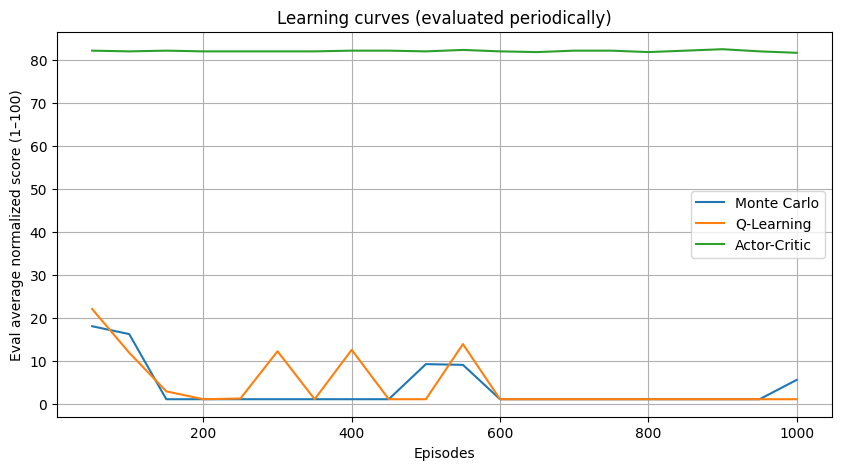


Playthrough — Monte Carlo (trained)
·🚂··········· | Step 1 | Action 0 | Reward 260.4 | raw_score 256.4
··🚂·········· | Step 2 | Action 1 | Reward 104.6 | raw_score 359.0
···🚂········· | Step 3 | Action 2 | Reward 93.4 | raw_score 452.4
····🚂········ | Step 4 | Action 2 | Reward 134.4 | raw_score 586.7
·····🚂······· | Step 5 | Action 1 | Reward 189.1 | raw_score 773.8
······🚂······ | Step 6 | Action 1 | Reward 57.7 | raw_score 829.5
·······🚂····· | Step 7 | Action 1 | Reward 135.1 | raw_score 962.7
········🚂···· | Step 8 | Action 2 | Reward 227.4 | raw_score 1190.1
·········🚂··· | Step 9 | Action 1 | Reward 31.3 | raw_score 1219.4
··········🚂·· | Step 10 | Action 1 | Reward 10.5 | raw_score 1227.8
···········🚂· | Step 11 | Action 0 | Reward 65.5 | raw_score 1289.4
············🚂 | Step 12 | Action 1 | Reward 19.1 | raw_score 1306.5
···········🚂· | Step 13 | Action 1 | Reward 155.6 | raw_score 1460.1
··········🚂·· | Step 14 | Action 2 | Reward 204.4 | raw_score 1664.5
·········🚂··· | Ste

In [ ]:
# ===============================
# AGENT TEST RUN (cleaned + fixed)
# ===============================

import matplotlib.pyplot as plt
from functools import partial
import time

# Environment constructor for fresh envs
def env_ctor():
    # Always create new env, difficulty scaling is inside TrainGameEnv
    return TrainGameEnv(seed=None, verbose=False)

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Instantiate agents
mc_agent = MonteCarloAgent(n_actions=3, eps=0.1)
q_agent = QLearningAgent(n_actions=3, alpha=0.1, gamma=0.99, eps=0.1)
ac_agent = ActorCriticAgent(state_dim=5, action_dim=3, lr=1e-3, gamma=0.99)

# Training parameters
EPISODES = 1000

print("Training Monte Carlo...")
mc_scores = train_mc(mc_agent, env_ctor, episodes=EPISODES)
print("Training Q-Learning...")
q_scores = train_q(q_agent, env_ctor, episodes=EPISODES)
print("Training Actor-Critic...")
ac_scores = train_ac(ac_agent, env_ctor, episodes=EPISODES)

# Convert training logs to X/Y for plotting
def to_xy(score_list):
    xs = [x for x, _ in score_list]
    ys = [y for _, y in score_list]
    return xs, ys

mc_x, mc_y = to_xy(mc_scores)
q_x, q_y = to_xy(q_scores)
ac_x, ac_y = to_xy(ac_scores)

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(mc_x, mc_y, label="Monte Carlo")
plt.plot(q_x, q_y, label="Q-Learning")
plt.plot(ac_x, ac_y, label="Actor-Critic")
plt.xlabel("Episodes")
plt.ylabel("Eval average normalized score (1–100)")
plt.title("Learning curves (evaluated periodically)")
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation playthroughs
def rollout_and_print(agent, title, max_steps=30):
    env = env_ctor()
    state = env.reset()
    print("\n" + "="*40)
    print(f"Playthrough — {title}")
    steps = 0

    while (not env.done) and steps < max_steps:
        if isinstance(agent, ActorCriticAgent):
            action, _, _ = agent.policy(state)
        else:
            action = agent.policy(state, greedy=True)

        state, reward, done, info = env.step(action)

        # ASCII track
        line = ["·"] * env.num_stations
        if 0 <= env.station_idx < len(line):
            line[env.station_idx] = "🚂"
        print("".join(line), f"| Step {steps+1} | Action {action} | Reward {reward:.1f} | raw_score {env.raw_score:.1f}")

        steps += 1
        time.sleep(0.04)

    norm, raw = env.final_score()  # no steps arg anymore
    print(f"Result {title}: normalized={norm}/100 raw={raw:.2f} reason={env.done_reason}")

# Show each trained agent
rollout_and_print(mc_agent, "Monte Carlo (trained)")
rollout_and_print(q_agent, "Q-Learning (trained)")
rollout_and_print(ac_agent, "Actor-Critic (trained)")


In [ ]:
def play_game_user(max_rounds=40, delay=0.2):
    """
    Play TrainGameEnv interactively as a human user.
    """
    env = TrainGameEnv(initial_capacity=100)
    print("🚆 Welcome to Dagdag o Lapad — User Mode 🚆")
    print("Actions: 0 = Dagdag (+100 cap), 1 = Lapad (+50 cap), 2 = None (no change)\n")

    for round_num in range(1, max_rounds+1):
        # Display current state
        print(f"\n=== Round {round_num} ===")
        print(f"📍 Station: {env.stations[env.station_idx]}")
        print(f"🚋 Capacity: {env.capacity} | Onboard: {env.passengers_onboard}")
        print(f"🕒 Hour: {env.sim_hour} | Direction: {'Eastbound' if env.direction==1 else 'Westbound'}")
        print(f"⚖️  Collapse Threshold: {getattr(env, 'collapse_thres00000hold', getattr(env, 'base_collapse_threshold', 10.0)):.2f}")
        print("Choose your action:")
        print("  0 = Dagdag (+100 cap)")
        print("  1 = Lapad  (+50 cap)")
        print("  2 = None   (no change)")

        # Get user input
        try:
            action = int(input("Enter action [0/1/2]: "))
            if action not in [0, 1, 2]:
                print("Invalid input. Defaulting to 2 (None).")
                action = 2
        except Exception:
            print("Invalid input. Defaulting to 2 (None).")
            action = 2

        # Step environment
        _, reward, done, info = env.step(action)
        print(f"✅ Reward: {reward:.2f} | Onboard after step: {env.passengers_onboard}")

        if done:
            print(f"\n❌ Game ended: {env.done_reason}")
            break

        import time
        time.sleep(delay)

    # Show final score
    try:
        final_norm, final_raw = env.final_score()
    except TypeError:
        # Some envs require survived_steps, fallback to station_visits
        final_norm, final_raw = env.final_score(getattr(env, "station_visits", 0))
    print("\n============================")
    print("🏁 Game Over!")
    print(f"📊 Raw Score: {final_raw:.2f}")
    print(f"⭐ Normalized Score: {final_norm}/100")
    print("============================")
    
play_game_user(max_rounds=40, delay=0.2)

🚆 Welcome to Dagdag o Lapad — User Mode 🚆
Actions: 0 = Dagdag (+100 cap), 1 = Lapad (+50 cap), 2 = None (no change)


=== Round 1 ===
📍 Station: Recto
🚋 Capacity: 100 | Onboard: 0
🕒 Hour: 3 | Direction: Eastbound
⚖️  Collapse Threshold: 10.00
Choose your action:
  0 = Dagdag (+100 cap)
  1 = Lapad  (+50 cap)
  2 = None   (no change)
✅ Reward: 285.60 | Onboard after step: 146

=== Round 2 ===
📍 Station: Legarda
🚋 Capacity: 200 | Onboard: 146
🕒 Hour: 5 | Direction: Eastbound
⚖️  Collapse Threshold: 10.00
Choose your action:
  0 = Dagdag (+100 cap)
  1 = Lapad  (+50 cap)
  2 = None   (no change)
✅ Reward: 40.98 | Onboard after step: 60

=== Round 3 ===
📍 Station: Pureza
🚋 Capacity: 300 | Onboard: 60
🕒 Hour: 5 | Direction: Eastbound
⚖️  Collapse Threshold: 10.00
Choose your action:
  0 = Dagdag (+100 cap)
  1 = Lapad  (+50 cap)
  2 = None   (no change)
Invalid input. Defaulting to 2 (None).
✅ Reward: 20.95 | Onboard after step: 30

=== Round 4 ===
📍 Station: V. Mapa
🚋 Capacity: 300 | Onboa